In [1]:
# http://num.pyro.ai/en/stable/examples/gp.html

# GP predictions: without kriging

In [2]:
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

In [3]:
# squared exponential kernel with diagonal noise term
def kernel(x1, x2, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((x1[:, None] - x2) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

In [24]:
def func(X):
    return X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)

# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=100):
    np.random.seed(0)
    X = jnp.linspace(-1, 3, N)
    Y = func(X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 3, N_test)
    Y_test = func(X_test)
    Y_test += sigma_obs * np.random.randn(N_test)
    Y_test -= jnp.mean(Y_test)
    Y_test /= jnp.std(Y_test)

    return X, Y, X_test, Y_test

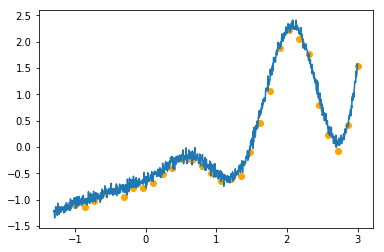

In [34]:
X_obs, Y_obs, X_pred, _ = get_data()
X_obs, Y_obs, X_pred_new, Y_pred_new = get_data(N_test=1000)
plt.scatter(X_obs, Y_obs, c='orange') # 30 training points
plt.plot(X_pred_new, Y_pred_new)
plt.show()

## No kriging - get predictions for free from the model

In [9]:
def model(X, Y_obs):
    # input X is a concatenation of X_obs and X_pred

    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.Exponential(5.))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))
    sigma = numpyro.sample("sigma", dist.LogNormal(0.0, 10.0))

    k = kernel(X, X, var, length, noise)
    
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k))
    
    numpyro.sample("Y_obs", dist.Normal(f[0:X_obs.shape[0]], sigma), obs=Y_obs)

In [10]:
X  = jnp.concatenate([X_obs, X_pred])

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [11]:
#mcmc.run(rng_key, X_obs=X_obs, Y_obs=Y_obs, X_pred=X_pred)
mcmc.run(rng_key, X=X, Y_obs=Y_obs)

sample: 100%|██████████| 2000/2000 [01:05<00:00, 30.71it/s, 31 steps of size 1.08e-01. acc. prob=0.76]


In [12]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           f[0]     -1.11      0.02     -1.11     -1.15     -1.08    439.76      1.00
           f[1]     -1.14      0.02     -1.14     -1.17     -1.11    457.83      1.00
           f[2]     -1.03      0.02     -1.03     -1.06     -1.00    441.40      1.00
           f[3]     -0.88      0.02     -0.87     -0.91     -0.85    629.53      1.00
           f[4]     -0.83      0.02     -0.83     -0.86     -0.80    742.49      1.00
           f[5]     -0.94      0.03     -0.95     -0.98     -0.90     68.71      1.02
           f[6]     -0.78      0.02     -0.78     -0.82     -0.75    382.12      1.01
           f[7]     -0.78      0.02     -0.78     -0.81     -0.75    761.79      1.00
           f[8]     -0.68      0.02     -0.68     -0.72     -0.65    795.64      1.00
           f[9]     -0.52      0.02     -0.52     -0.55     -0.48    545.40      1.00
          f[10]     -0.40      0.02     -0.40     -0.

In [13]:
samples = mcmc.get_samples()
f = samples['f']
print(f.shape)
f_pred = f[:,X_obs.shape[0]:]
print(f_pred.shape)

f_mean = jnp.mean(f_pred, axis=0)
f_hdpi = hpdi(f_pred, 0.9)

(1000, 130)
(1000, 100)


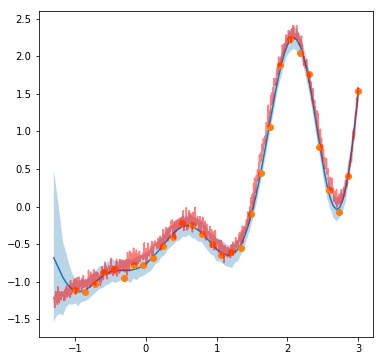

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(X_pred, f_mean)
ax.plot(X_obs, Y_obs, 'o')
ax.plot(X_pred_new, Y_pred_new, c='red', alpha=0.5)
ax.fill_between(X_pred, f_hdpi[0], f_hdpi[1], alpha=0.3, interpolate=True)
plt.show()